In [3]:
from fastai.vision.all import *

In [4]:
df = pd.read_csv("./data/train.csv")
df = df.groupby('image_id')['class_name'].apply(lambda x: ','.join(set(x))).reset_index()
# df["class_name"] = df["class_name"].apply(lambda x: x.split(","))
print(df.head(10))

                           image_id  \
0  000434271f63a053c4128a0ba6352c7f   
1  00053190460d56c53cc3e57321387478   
2  0005e8e3701dfb1dd93d53e2ff537b6e   
3  0006e0a85696f6bb578e84fafa9a5607   
4  0007d316f756b3fa0baea2ff514ce945   
5  000ae00eb3942d27e0b97903dd563a6e   
6  000d68e42b71d3eac10ccc077aba07c1   
7  00150343289f317a0ad5629d5b7d9ef9   
8  00176f7e1b1cb835123f95960b9a9efd   
9  001d127bad87592efe45a5c7678f8b8d   

                                                                                                         class_name  
0                                                                                                        No finding  
1                                                                                                        No finding  
2                                                               Consolidation,Infiltration,Lung Opacity,Nodule/Mass  
3                                                                                                 

In [5]:
path = "./data"

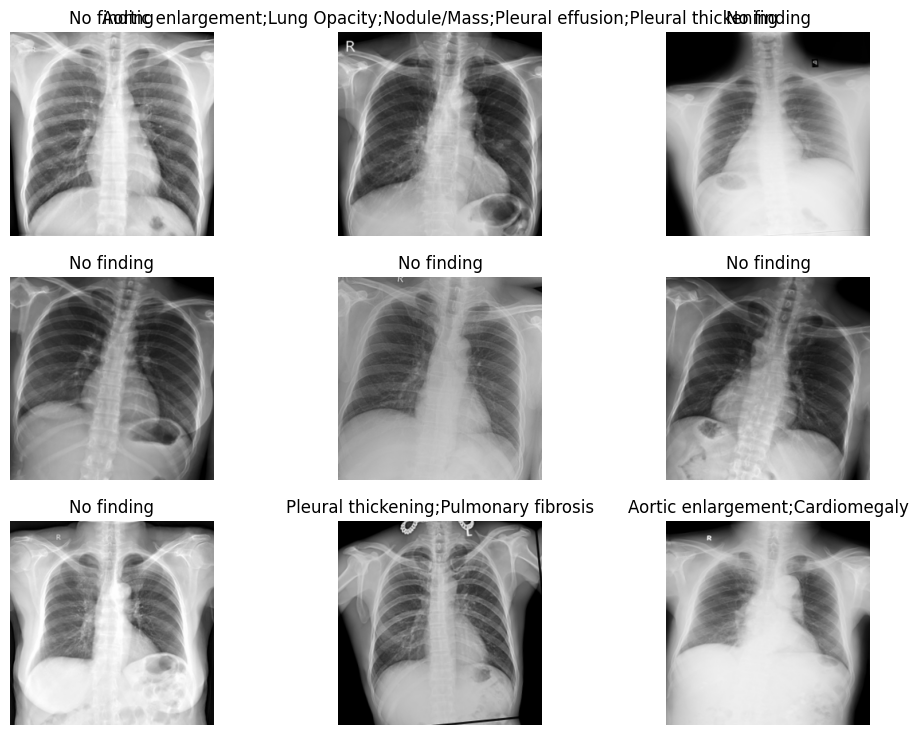

In [6]:
batch_tfms = aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader("image_id", pref=f'{path}/train/', suff='.png'),
                   splitter=RandomSplitter(),
                   get_y=ColReader("class_name", label_delim=','),
                   batch_tfms = batch_tfms)


dls = db.dataloaders(df)

dls.show_batch(max_n=9, figsize=(12,9))

In [7]:
dls.c

15

In [8]:
dls.vocab

['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'No finding', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']

In [9]:
from torchvision.models import resnet34
from fastai.metrics import accuracy_multi


In [10]:
learn = vision_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])


SuggestedLRs(valley=0.0030199517495930195)

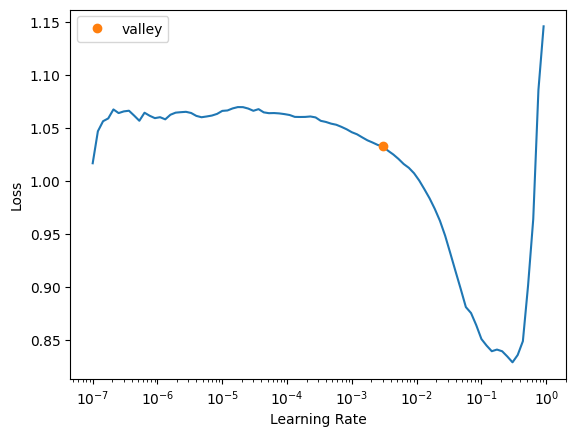

In [11]:
learn.lr_find()

In [12]:
lr = 0.0030199517495930195
learn = learn.to_fp16()

In [13]:
learn.fit_one_cycle(5, slice(lr))

/Users/rahulnayanegali/ai/MedXrayAI/env/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/rahulnayanegali/ai/MedXrayAI/env/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.437734,0.208175,0.921489,02:13
1,0.205721,0.176265,0.932378,02:11
2,0.180302,0.164113,0.936533,02:12
3,0.165684,0.159077,0.937134,02:11
4,0.162395,0.158485,0.937045,02:12


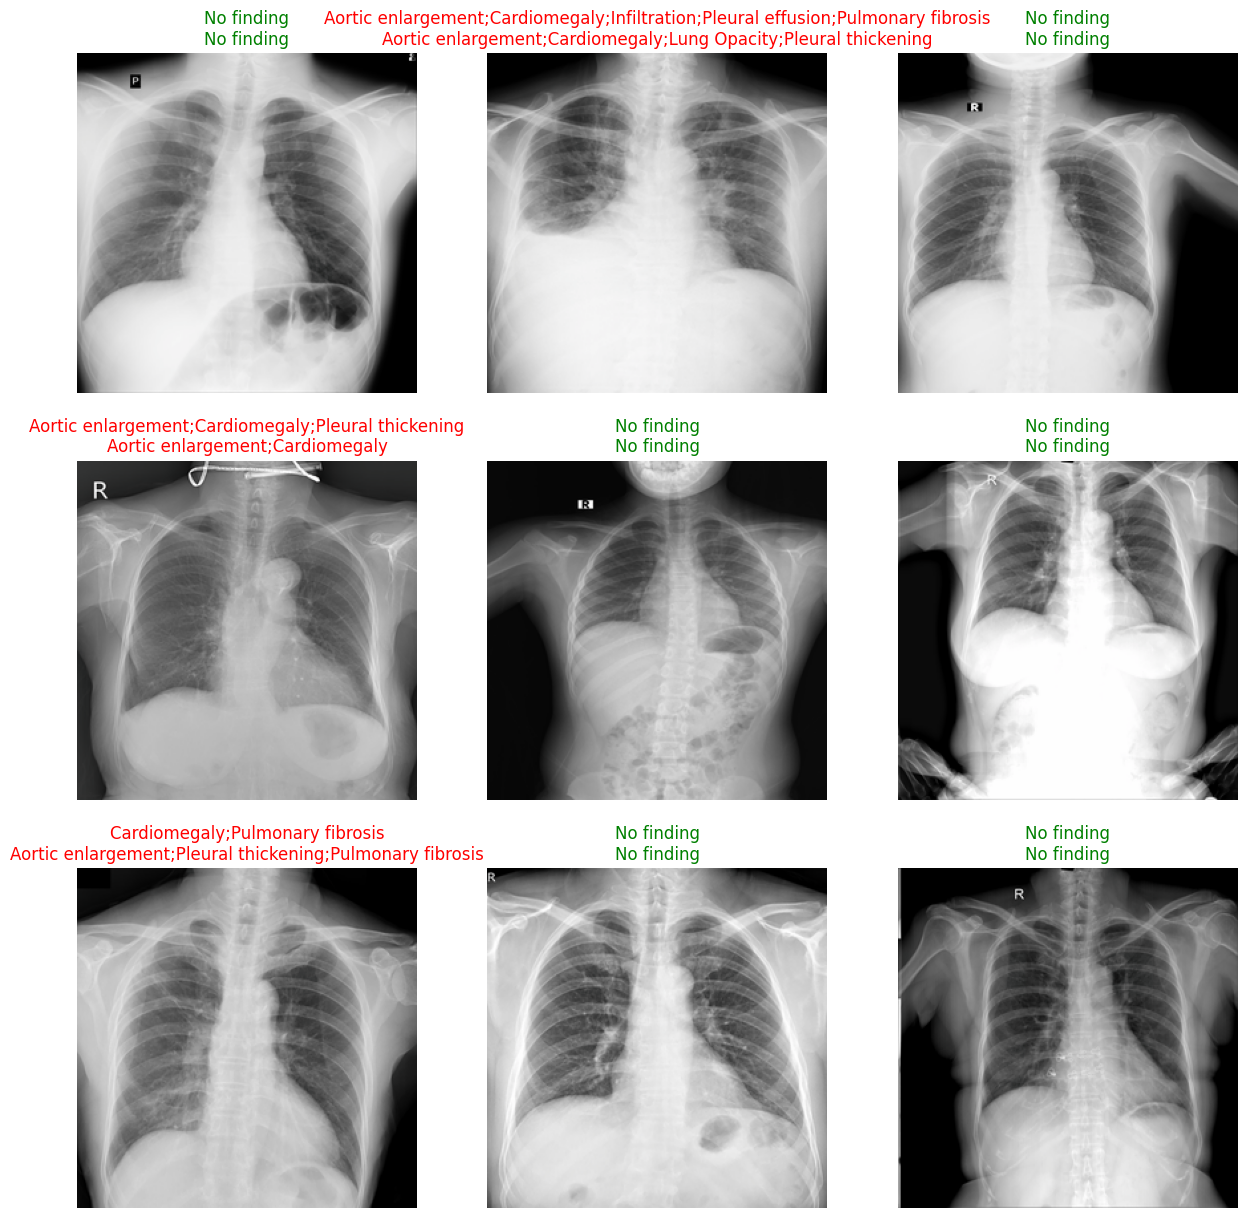

In [12]:
learn.show_results(figsize=(15,15))

In [2]:
interp = ClassificationInterpretation.from_learner(learn)

NameError: name 'learn' is not defined

,target,predicted,probabilities,loss
0,ILD;Infiltration;Lung Opacity;Other lesion;Pleural effusion;Pleural thickening;Pulmonary fibrosis,No finding,"tensor([4.6483e-04, 7.0375e-05, 2.3089e-04, 3.2484e-04, 1.9570e-04, 4.5814e-04,\n 2.7819e-03, 2.4634e-03, 9.9424e-01, 1.2674e-03, 1.7929e-03, 7.5491e-04,\n 3.1348e-03, 1.4389e-04, 5.9563e-03])",3.2760138511657715
1,Infiltration;Other lesion;Pleural effusion;Pleural thickening;Pulmonary fibrosis,No finding,"tensor([4.5690e-03, 1.0009e-04, 5.7262e-04, 1.6074e-03, 9.4906e-05, 5.1900e-04,\n 1.2024e-03, 1.9027e-03, 9.9162e-01, 1.8451e-03, 5.3591e-03, 8.7718e-04,\n 9.1019e-03, 9.1490e-05, 4.9630e-03])",2.252628803253174
2,Atelectasis;Consolidation;ILD;Other lesion;Pulmonary fibrosis,No finding,"tensor([1.9551e-02, 2.5966e-03, 2.6488e-02, 1.0372e-02, 2.5071e-03, 9.8654e-03,\n 5.2437e-03, 2.3192e-02, 9.7553e-01, 2.2398e-02, 3.4881e-02, 4.1304e-03,\n 2.4011e-02, 6.3360e-04, 2.1084e-02])",1.8415744304656982
3,Pleural thickening;Pneumothorax;Pulmonary fibrosis,No finding,"tensor([2.1186e-04, 2.7758e-05, 8.2371e-04, 5.3936e-04, 2.5551e-04, 4.1523e-04,\n 3.7300e-03, 2.3060e-03, 9.9663e-01, 1.6148e-03, 1.6416e-03, 6.1558e-04,\n 1.4405e-03, 1.0008e-03, 5.7208e-03])",1.621195673942566
4,Atelectasis;Lung Opacity;Nodule/Mass;Other lesion;Pleural effusion,No finding,"tensor([0.0119, 0.0042, 0.0230, 0.0107, 0.0119, 0.0174, 0.0201, 0.0316, 0.9393,\n 0.0175, 0.0194, 0.0127, 0.0226, 0.0025, 0.0389])",1.6153463125228882
5,Atelectasis;Consolidation;Lung Opacity;Pleural effusion;Pleural thickening;Pneumothorax,Aortic enlargement;Cardiomegaly,"tensor([0.7686, 0.0106, 0.0713, 0.7600, 0.0229, 0.0279, 0.0405, 0.1550, 0.1112,\n 0.1706, 0.2036, 0.1192, 0.3446, 0.0051, 0.1794])",1.4946168661117554
6,Aortic enlargement;Pleural effusion;Pleural thickening,No finding,"tensor([2.6796e-03, 2.7070e-05, 6.6874e-04, 3.6065e-04, 3.9741e-05, 7.6097e-04,\n 1.1646e-03, 1.0731e-03, 9.9230e-01, 2.4067e-03, 2.9554e-03, 2.0038e-03,\n 7.4150e-03, 7.3999e-05, 4.5818e-03])",1.4612938165664673
7,Aortic enlargement;Consolidation;Lung Opacity;Other lesion;Pleural effusion;Pleural thickening;Pneumothorax,No finding,"tensor([0.0533, 0.0147, 0.0300, 0.0131, 0.0209, 0.0340, 0.1103, 0.1114, 0.7457,\n 0.1243, 0.1230, 0.0694, 0.1280, 0.0245, 0.2357])",1.433772325515747
8,Calcification;Consolidation;Nodule/Mass;Pleural effusion;Pleural thickening;Pneumothorax;Pulmonary fibrosis,Aortic enlargement,"tensor([0.7161, 0.0098, 0.0309, 0.4600, 0.0205, 0.0229, 0.0778, 0.1725, 0.0601,\n 0.0821, 0.1233, 0.1535, 0.4680, 0.0074, 0.2853])",1.401945948600769
9,Aortic enlargement;Cardiomegaly;Pleural thickening,No finding,"tensor([7.4139e-03, 2.5504e-04, 7.5868e-04, 5.5109e-03, 5.1964e-04, 1.6358e-04,\n 1.4430e-03, 5.2048e-03, 9.9180e-01, 2.5375e-03, 4.1486e-03, 1.5013e-03,\n 2.7115e-03, 6.8266e-04, 2.2367e-03])",1.3892219066619873


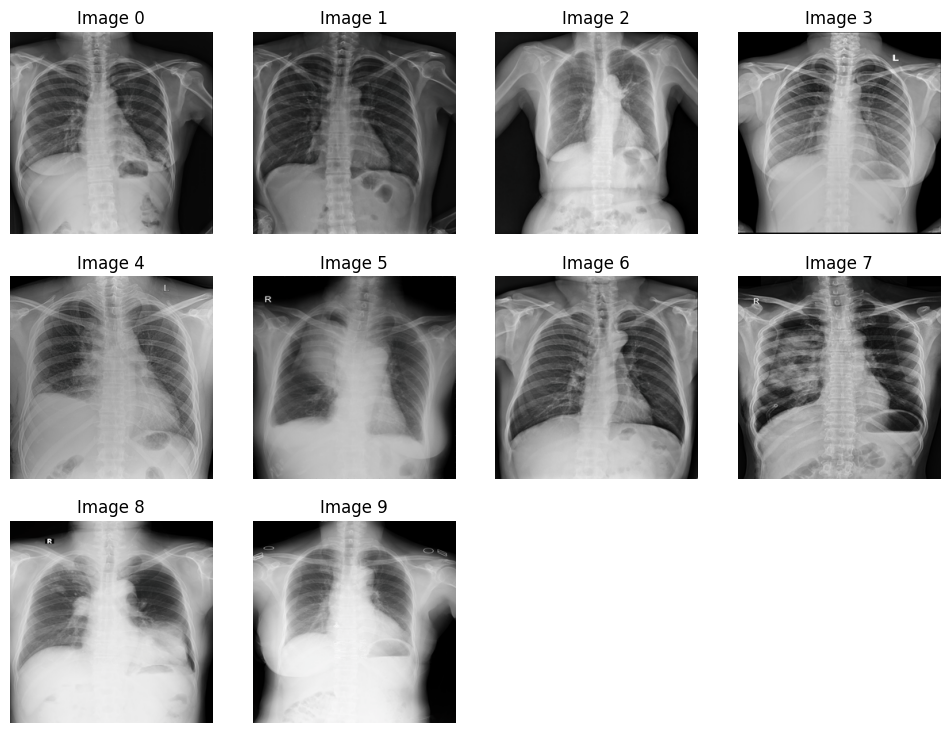

In [14]:
interp.plot_top_losses(k=10)

In [15]:
interp.most_confused()

/Users/rahulnayanegali/ai/MedXrayAI/env/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/rahulnayanegali/ai/MedXrayAI/env/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[('Atelectasis', 'Aortic enlargement', 2048),
 ('Aortic enlargement', 'Atelectasis', 595)]

In [16]:
from fastai.metrics import RocAucMulti
roc_auc = RocAucMulti(average='macro')

In [18]:
learn = vision_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi, roc_auc])

In [19]:
learn.freeze()
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,time
0,0.260323,0.184950,0.932489,0.834086,02:09


In [20]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,time
0,0.174354,0.169130,0.936933,0.911254,03:07
1,0.151196,0.139015,0.945800,0.925584,03:10
2,0.136339,0.125037,0.950911,0.937065,03:09
3,0.119047,0.114200,0.954511,0.949402,03:14
4,0.105603,0.110569,0.955911,0.950842,03:18


In [1]:
# Saving the model
learn.export("trained_model_multi.pkl")


NameError: name 'learn' is not defined

In [22]:
# Testing
import pandas as pd

In [24]:
# Load the trained model
model = load_learner("trained_model.pkl")

# Load your new untrained image
new_image_path = "6acc13406eda521dedfca734ddbe3e25.png"

# Preprocess the new image
img = PILImage.create(new_image_path)

# Make predictions
preds, _, _ = model.predict(img)

# Display predictions
print(preds)

['Aortic enlargement', 'Cardiomegaly']
